<a href="https://colab.research.google.com/github/felippe-ribeiro/AulasIAFIAP/blob/main/Sistema_de_Suporte_ao_Diagn%C3%B3stico_de_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tech Challenge
##Desafio
 Um grande hospital universitário busca implementar um sistema inteligente
de suporte ao diagnóstico, capaz de ajudar médicos(as) e equipes clínicas na
análise inicial de exames e no processamento de dados médicos.
Com um volume crescente de pacientes e exames, como radiografias,
tomografias, ressonâncias e prontuários digitalizados, o hospital precisa de
soluções que acelerem a triagem e apoiem as decisões médicas, reduzindo erros
e otimizando o tempo dos profissionais.

###Objetivo
Comparar a performance de diferentes algoritmos de classificação supervisionada para identificar a presença da doença

#Sistema de Suporte ao Diagnóstico de Diabetes

Modelo de ML capaz de auxiliar na triagem de pacientes com riscos de diabetes. Dataset Prima Indians Diabetes Database.
Classificação binária: predizer se o paciente testará positivo(1), ou negativo (0). Foi usado como base para o diagnóstico glicose, pressão sanguínea, IMC entre olutros.

Dataset:
[DataSet Pima Indian](https://www.kaggle.com/datasets/mathchi/diabetes-data-set?resource=download)

#importar dados e Inspeção

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

df = pd.read_csv('diabetes.csv')

print("Dimensão:", df.shape)


Dimensão: (768, 9)


In [27]:
print("Tipos de Dados:")
df.info()

Tipos de Dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [28]:
print("Descrição:")
df.describe()

Descrição:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Variaveis: Glucose, BloodPressure, SkinThickness, Insulin e BMI, mostram valores minimos igual a 0. Não é possível esses valores em pressão sanguínea e glicose.
Portanto podemos assumir que são dados não preenchidos ou faltando.

#Análise Exploratório de Dados

**1 -** As classes diabéticos vs. não Diabéticos estão equilibradas ?

**2 -** Como as var. principais se comportam em relação ao desfecho ?

**3 -** Existem variaveis redundantes ou fortemente explicativas ?

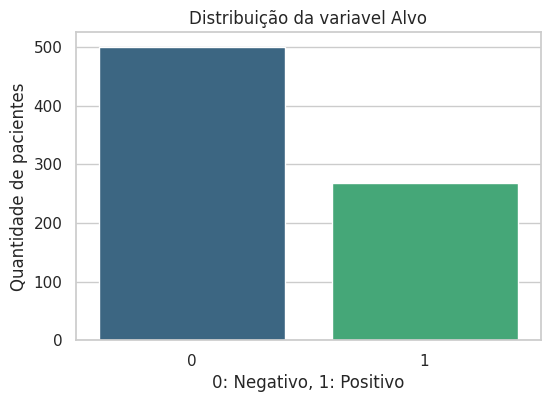

Negativos: 500 (65.10%)
Positivos: 268 (34.90%)


In [29]:
#Pergunta 1:
#distribuição das classes:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='Outcome', data=df, palette='viridis')
plt.title('Distribuição da variavel Alvo')
plt.xlabel('0: Negativo, 1: Positivo')
plt.ylabel('Quantidade de pacientes')


plt.show()

#proporção
neg, pos = df['Outcome'].value_counts()
print(f"Negativos: {neg} ({neg/len(df)*100:.2f}%)")
print(f"Positivos: {pos} ({pos/len(df)*100:.2f}%)")

O dataset não é balanceado, acurácia simples provavelmente não é a melhor métrica de avaliação.
Vamos observar Recall e F1-score, pois para erros médicos Falso negativo é muito mais critico do que um falso positivo.
Em suma: Dizer que um paciente doente está saudável é muito pior.

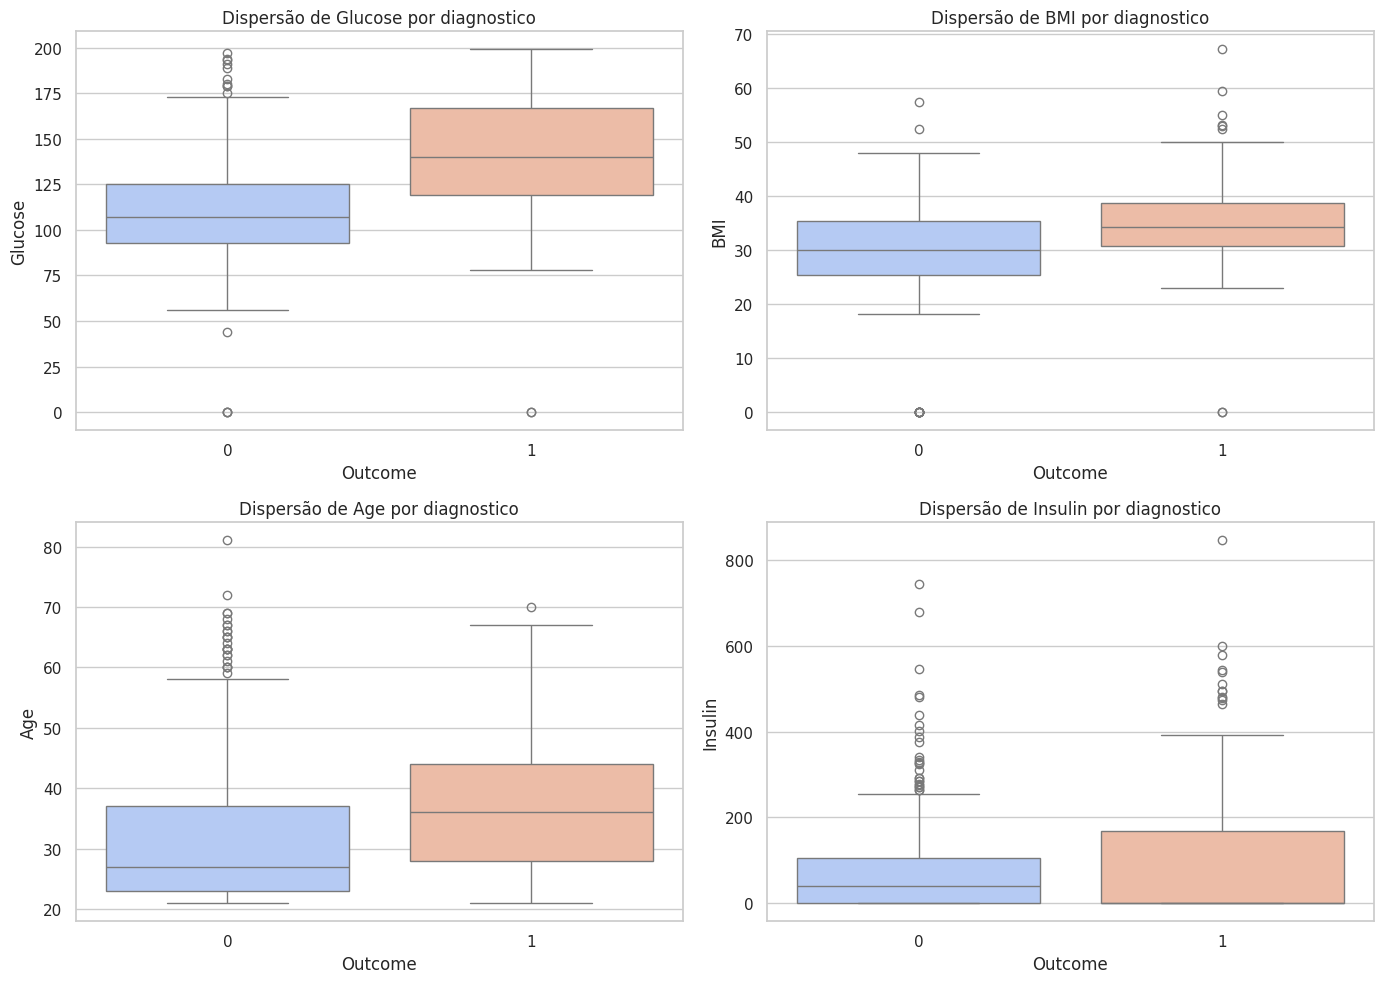

In [30]:
#Pergunta 2
#Quais atributos mais se diferenciam dos grupos ?

feature_interesse = ['Glucose', 'BMI', 'Age', 'Insulin']

plt.figure(figsize=(14, 10))
for i, col in enumerate(feature_interesse):
  plt.subplot(2, 2, i+1)
  sns.boxplot(x='Outcome', y=col, data=df, palette='coolwarm')
  plt.title(f'Dispersão de {col} por diagnostico')

plt.tight_layout()
plt.show()

##Distinções:

* **Glucose:** é o mais forte visivelmente. A mediana da glicose para pacientes diabeticos é muito superior aos dos não diabeticos.

* **Age:** Pacientes diabéticos geralmente são mais bvelhos, no embora tenhamos bastante sobreposição e outliers no grupo saudável.

* **BMI:** Este também apresenta mediana superior no grupo positivo, obesidade também pode ser um fator de risco.

* **Insulin:** Muitos outliers, a distribuição fica prejudicada pelos valores 0.

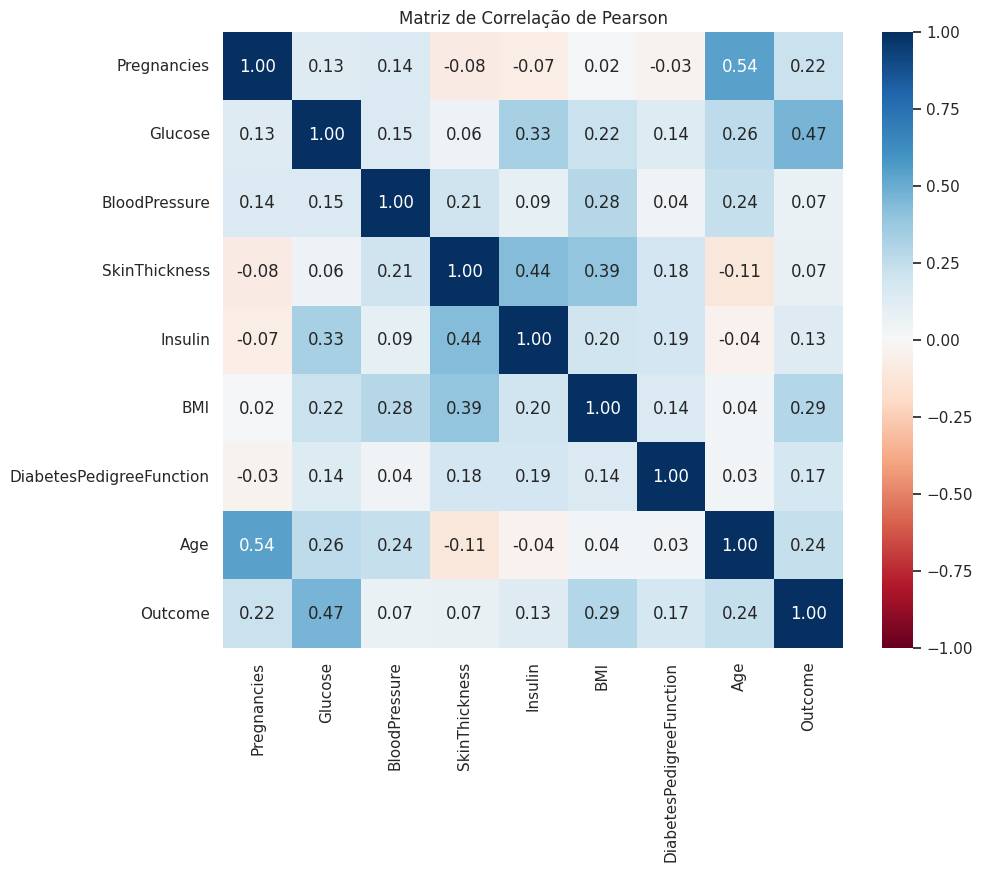

In [31]:
#Pergunta 3.
#Correlação entre variaveis

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1, fmt=".2f")
plt.title('Matriz de Correlação de Pearson')
plt.show()

Confirmação de que glicose tem a maior correlação linear positiva com o alvo (0,47), temos também correlação moderada entre Age e Pregnancies.

#Pré-processamento e Limpeza

1 - Substituir zeros em 'Glucose', 'BloodPressure', 'SkiunThickness', 'Insulin' e 'BMI pela mediana para evitar distorção por outliers

2- Divisão entre treino e teste

3 - Normalização: Padronizar escalas.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#Tratando zeros --> mudar de zeros para NAN
cols_to_fix = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_copy = df.copy()
df_copy[cols_to_fix] = df_copy[cols_to_fix].replace(0, np.nan)



In [37]:
#Preenchendo com mediana
imputer = SimpleImputer(strategy='median')
df_copy[cols_to_fix] = imputer.fit_transform(df_copy[cols_to_fix])

In [38]:
#separação
X = df_copy.drop('Outcome', axis=1)
y = df_copy['Outcome']

In [39]:
#Treino e teste - stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


In [42]:
#StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Modelagem

Abordagens selecionadas para testes: **KNN, SVM e Random Forest**.

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [44]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=9),
    "SVM (Kernel Linear)": SVC(kernel='linear', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [49]:
results = {}
for name, model in models.items():
  #Train
  model.fit(X_train_scaled, y_train)
  #Predição
  y_pred = model.predict(X_test_scaled)
  #Métricas
  acc = accuracy_score(y_test, y_pred)
  results[name] = model #Modelo jã treinado

  print(f"******Relatório para: {name} ******")
  print(f"Acurácia: {acc:.4f}")
  print(classification_report(y_test, y_pred))
  print("*" * 50)
  print('\n\n')

******Relatório para: KNN ******
Acurácia: 0.7403
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       100
           1       0.63      0.61      0.62        54

    accuracy                           0.74       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154

**************************************************



******Relatório para: SVM (Kernel Linear) ******
Acurácia: 0.7013
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.59      0.48      0.53        54

    accuracy                           0.70       154
   macro avg       0.67      0.65      0.66       154
weighted avg       0.69      0.70      0.69       154

**************************************************



******Relatório para: Random Forest ******
Acurácia: 0.7792
              precision    recall  f1-score   support

       

**KNN** Teve um bom desempenho, mas é sensível a ruídos locais.

**SVM** mostrou bastante consistencia, indicando que as classes possuem separabilidade linear

**Random Forest** normalmente apresenta maior robustez em datasets medicos por libar bem com relações não lineares entre as features (ex. idade e glicose)


A seguir uma analise aprofundada com matris de confusão e Curva ROC

Acuracia sozinha pode esconder erros de falso negatico, vamos ver onde cada um erra


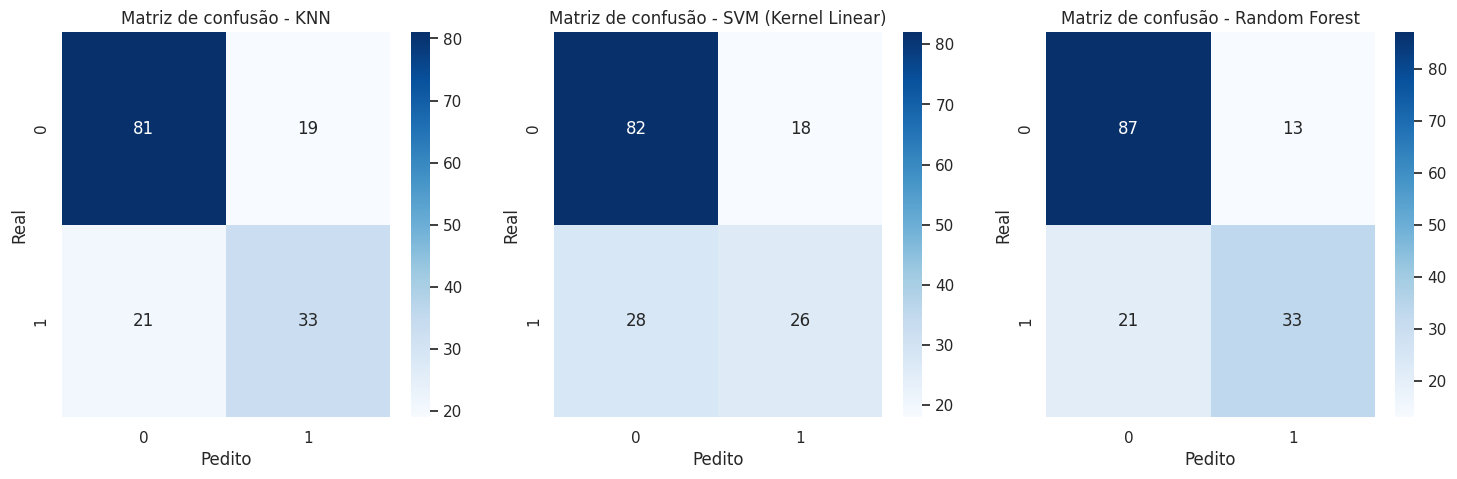

In [56]:
fig, axes = plt.subplots(1,3, figsize=(18, 5))

for i, (name, model) in enumerate(results.items()):
  y_pred = model.predict(X_test_scaled)
  cm = confusion_matrix(y_test, y_pred)

  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
  axes[i].set_title(f'Matriz de confusão - {name}')
  axes[i].set_xlabel('Pedito')
  axes[i].set_ylabel('Real')

plt.show()

No quadrante inferior esquerdo --> Falsos negativos. Este erro conforme descrito é o de maior risco.
Inferior direito --> Verdadeiros positivos
Preferivel: Maximiza Verdadeiro positivo e minimiza falsos negativos, mesmo com acuracia globnal menor

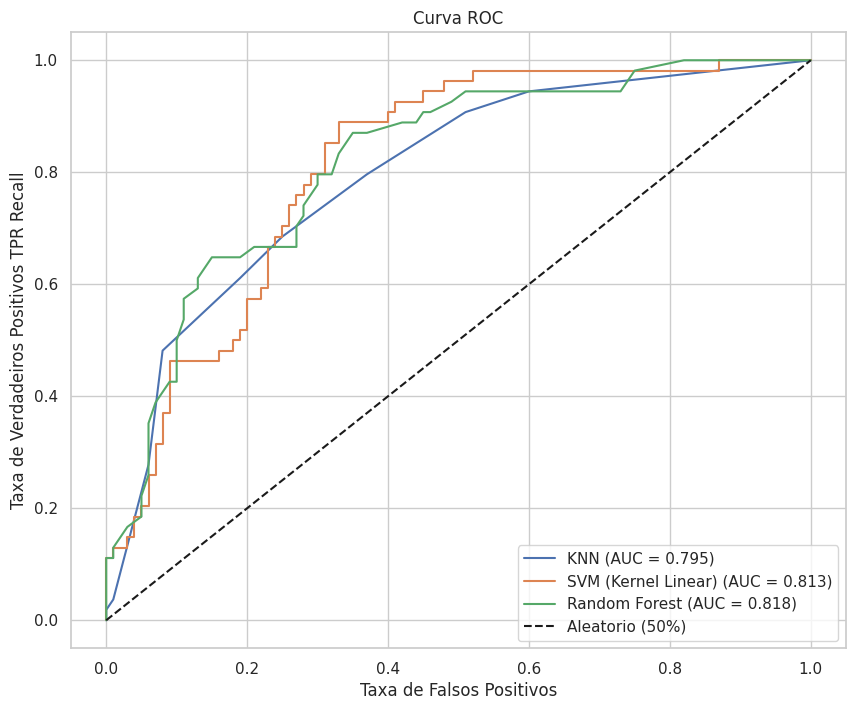

In [57]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(10, 8))

for name, model in results.items():
  #probabilidades de classes positivas
  y_proba = model.predict_proba(X_test_scaled)[:, 1]

  #Calculo Curva
  fpr, tpr, _ = roc_curve(y_test, y_proba)
  auc = roc_auc_score(y_test, y_proba)

  plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (50%)')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos TPR Recall')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

O modelo com a maior AUC é o que representa maior capacidade de distinguir corretamente entre pacientes com e sem diabetes, indiferente do limiar de classificação escolhido.
A disputa ficou entre **SVM** e **Random Forest**.

#**Conclusão**
Desenvolvi nesse projeto um pipeline completo de ML para predição de diabetes.
Etapas e conclusões:

1. **Dados:** Identifiquei e tratei os dados faltantes camuflados com zero, etapa crítica para evitar viés.
2. **Análise:** Confirmei que Glicose e IMC são os preditores mais fortes.
3. **Modelagem:** O modelo **Random Forest** apresentou o melhor equilibrio entre Sensibilidade e Especificidade (AUC Score)

Este modelo pode ser usado como ferramenta de **segunda opinião** para triagem médica, alertando para casos de alto risco que precisam de exames complementares.